# Homework 2

### Instructions
Download this jupyer notebook (button at the top of the page or download from the Github repository). Provide your answers as Markdown text, Python code, and/or produce plots as appropriate. The notebook should run all the cells in order without errors.  
Submit both the `.ipynb` and a `.pdf` to Canvas.

Make sure the `.pdf` has all the relevant outputs showing. To save as `.pdf` you can first export the notebook as `.html`, open it in a browers and then "Print to PDF". 

**NOTE:** As we will be sharing the files for peer grading, please keep your submission anonymous.

# Problem 4 (Trajectory optimization - sequential quadratic programming)

In this problem, you will explore sequential quadratic programming, an algorithm where you successively convexify your nonlinear trajectory optmization problem about a previous solution, and reduce the problem into a quadratic program.
Assuming the cost objective is already quadratic, the bulk of the convexification will be focused on linearizing the dynamics and constraints about a previous solution.

Below is an implementation of SQP with a dynamically extended simple car model avoiding *one* circular obstacle. You should read each line of the code; the following questions will be based on your understanding of the SQP algorithm and following implementation.

The dynamically extended simple car has the following dynamics:

$$
\begin{bmatrix}
\dot{x} \\ \dot{y} \\ \dot{\theta} \\ \dot{v}
\end{bmatrix}
= 
\begin{bmatrix}
v\cos\theta\\ v\sin\theta \\ \frac{v}{L}\tilde{\delta} \\ a
\end{bmatrix}, \qquad u = \begin{bmatrix} \tilde{\delta} \\ a \end{bmatrix} \: \text{where} \: \tilde{\delta} = \tan\delta
$$

Note: We have made the substitution $\tilde{\delta} = \tan\delta$ so that the system is control affine since the mapping is bijective over $(-\pi/2, \pi/2)$

Let $g(x; x_\mathrm{ob}, r)$ denote a function that measure how far away the state $x$ is from a circular obstacle centered at $x_\mathrm{ob}$ with radius $r$. 


You need to install a new package `dynamaxsys`.
You can install it by running 
```
pip install dynamaxsys==0.0.3
```

Alternatively, you can clone it locally by following the instructions here `https://github.com/UW-CTRL/dynamaxsys.git`

In [2]:

import cvxpy as cp # import cvxpy

# in this problem, we will use the dynamaxsys library to import dynamical systems implemented in JAX: https://github.com/UW-CTRL/dynamaxsys
from dynamaxsys.simplecar import DynamicallyExtendedSimpleCar
from dynamaxsys.base import get_discrete_time_dynamics
from dynamaxsys.utils import linearize


import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import functools
import functools
from ipywidgets import interact


In [3]:
# define the robot dynamics
wheelbase = 1.0
dt = 0.1
ct_robot_dynamics = DynamicallyExtendedSimpleCar(wheelbase=wheelbase) # robot dynamics
dt_robot_dynamics = get_discrete_time_dynamics(ct_robot_dynamics, dt=dt) # discrete time dynamics
state_dim = dt_robot_dynamics.state_dim
control_dim = dt_robot_dynamics.control_dim


In [5]:
# some helper functions

# define obstacle function g(x) >= 0
# where g(x) is the distance from the obstacle
@jax.jit
def obstacle_constraint(state, obstacle, radius):
    return jnp.linalg.norm(state[:2] - obstacle[:2]) - radius

# function to simulate the discrete time dynamics given initial state and control sequence
@functools.partial(jax.jit, static_argnames=["dt_dynamics"])
def simulate_discrete_time_dynamics(dt_dynamics, state, controls, t0, dt):
    states = [state]
    t = t0
    for c in controls:
        state = dt_dynamics(state, c, t)
        states.append(state)
        t += dt
    return jnp.stack(states)

# jit the linearize constraint functions to make it run faster
linearize_obstacle = jax.jit(jax.vmap(jax.grad(obstacle_constraint), in_axes=[0, None, None]))

In [33]:
# set up the problem parameters
planning_horizon = 25 # length of the planning horizon
num_time_steps = 50 # number of time steps to simulate
num_sqp_iterations = 15 # number of SQP iterations
t = 0. # this doesn't affect anything, but a value is needed 

# control and velocity limits
v_max = 1.5
v_min = 0.
acceleration_max = 1.0
acceleration_min = -1.0
steering_max = 0.5
steering_min = -0.5

# obstacle parameters
obstacle_location = jnp.stack([jnp.array([1.0, 0.0]), jnp.array([3, -0.5])]) # obstacle location
obstacle_radius = 0.5 # obstacle radius
robot_radius = 0.1 # robot radius


## (a) The inner quadratic program problem

Take a close look at the following two cells. Let $x^\mathrm{prev}_t$ and $u^\mathrm{prev}_t$ denote the state and control at time $t$ from the *previous* SQP iteration.
Write out the exact quadratic program that is being solved at each SQP iteration. Keep variables/parameters in terms of their names and don't use their numerical values. For example, use $\beta_1$ instead of 0.2.


Additionally, describe what each term in the problem represents, and the expression for them. That is, define mathematically what they are using mathematical expressions, their role within the optimization problem, and describe in words the interpretation of them. 


Write the QP here....

$$ ... $$

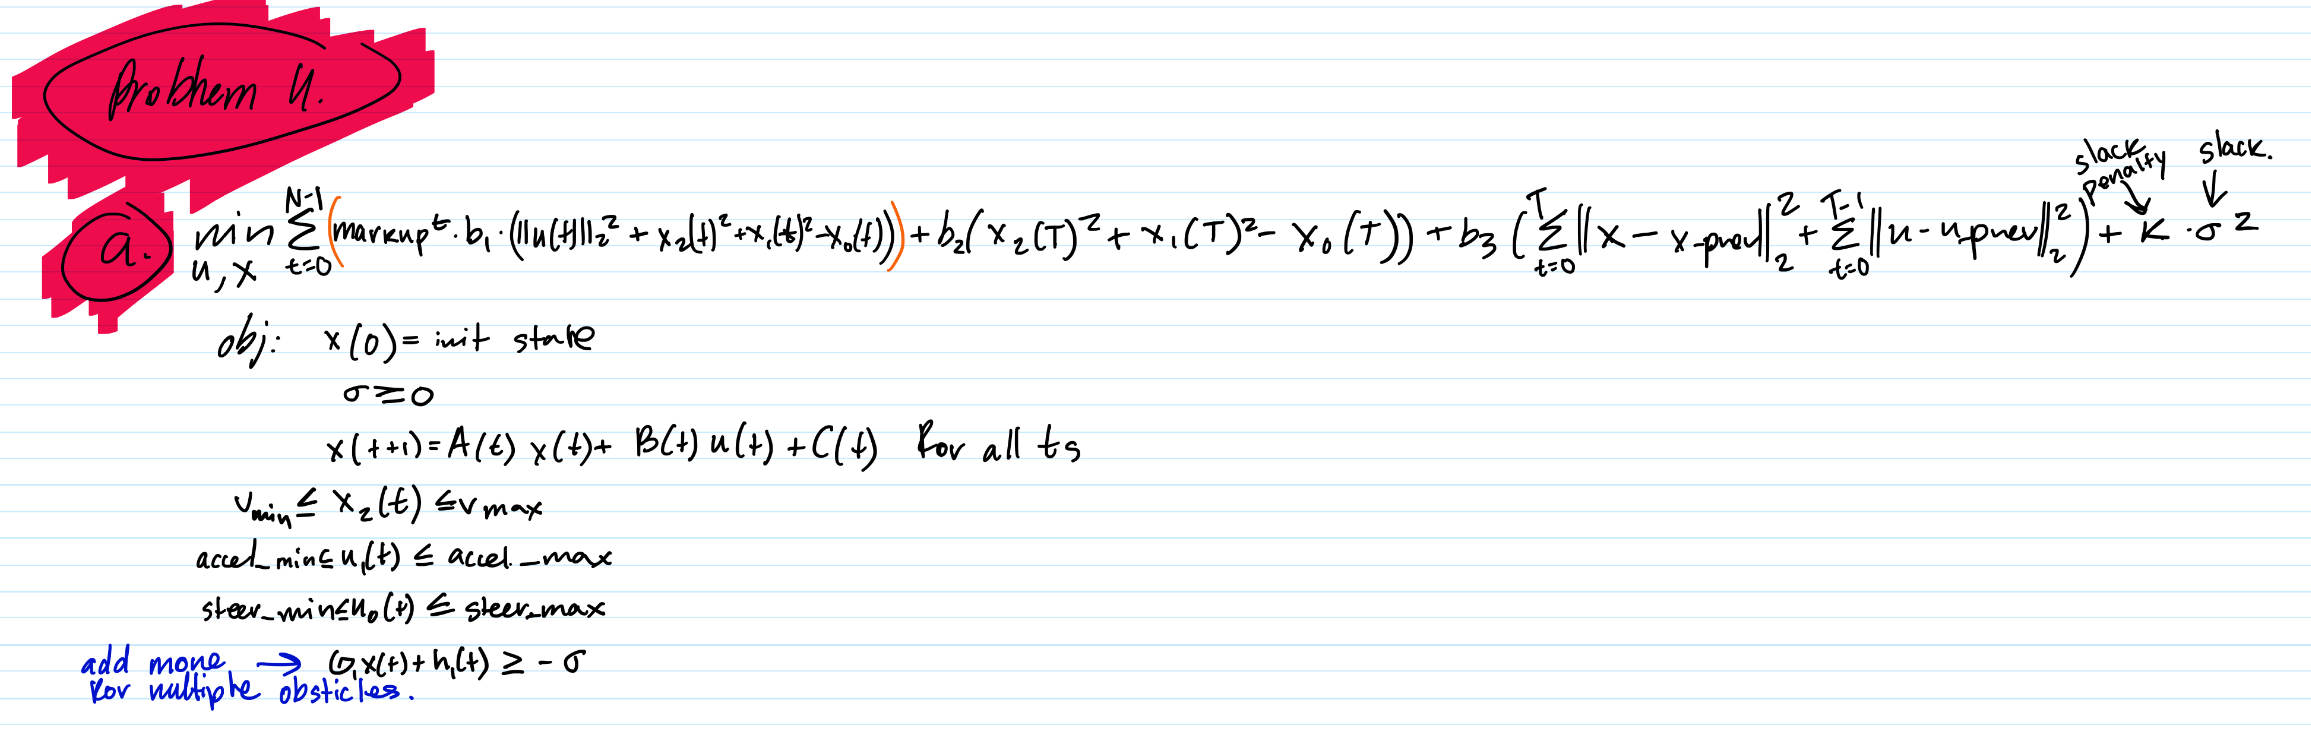

In [34]:
from IPython.display import Image
Image(filename='IMG_6069.jpeg')


x is state, u in input, and betas are penalty coefficients. So Beta 3 means you care about how big steps do x and u take, so favors smoothness. Beta 2 cares about the terminal cost function. Beta 1 controls trajectory step term cost, so cost at each step of producing trajectories. k is a slack penalty which controls how relaxed or tight to you want this to be.  γ favors step early on versus late.

In [35]:
# set up cvxpy problem variables and parameters
xs = cp.Variable([planning_horizon+1, state_dim])  # cvx variable for states
us = cp.Variable([planning_horizon, control_dim])  # cvx variable for controls
slack = cp.Variable(1) # slack variable to make sure the problem is feasible
As = [cp.Parameter([state_dim, state_dim]) for _ in range(planning_horizon)]  # parameters for linearized dynamics
Bs = [cp.Parameter([state_dim, control_dim]) for _ in range(planning_horizon)] # parameters for linearized dynamics
Cs = [cp.Parameter([state_dim]) for _ in range(planning_horizon)] # parameters for linearized dynamics

Gs = [cp.Parameter([state_dim]) for _ in range(planning_horizon+1)] # parameters for linearized constraints
hs = [cp.Parameter(1) for _ in range(planning_horizon+1)] # parameters for linearized constraints
Gs2 = [cp.Parameter([state_dim]) for _ in range(planning_horizon+1)] # parameters for linearized constraints
hs2 = [cp.Parameter(1) for _ in range(planning_horizon+1)] # parameters for linearized constraints

xs_previous = cp.Parameter([planning_horizon+1, state_dim]) # parameter for previous solution
us_previous = cp.Parameter([planning_horizon, control_dim]) # parameter for previous solution
initial_state = cp.Parameter([state_dim]) # parameter for current robot state

In [48]:
# set up cvxpy problem cost and constraints
beta1 = 0.2 # coefficient for control effort
beta2 = 5. # coefficient for progress
beta3 = 10 # coefficient for trust region
slack_penalty = 1000. # coefficient for slack variable
markup = 0.95

objective = beta2 * (xs[-1,2]**2 + xs[-1,1]**2 - xs[-1,0]) + beta3 * (cp.sum_squares(xs - xs_previous) + cp.sum_squares(us - us_previous)) + slack_penalty * slack**2
constraints = [xs[0] == initial_state, slack >= 0] # initial state and slack constraint
for t in range(planning_horizon):
    objective += (beta1 * cp.sum_squares(us[t]) + beta1 * (xs[t,2]**2 + xs[t,1]**2 - xs[t,0]) ) * markup**t
    constraints += [xs[t+1] == As[t] @ xs[t] + Bs[t] @ us[t] + Cs[t]] # dynamics constraint
    constraints += [xs[t,-1] <= v_max, xs[t,-1] >= v_min, us[t,1] <= acceleration_max, us[t,1] >= acceleration_min, us[t,0] <= steering_max, us[t,0] >= steering_min] # control and velocity limit constraints
    constraints += [Gs[t] @ xs[t] + hs[t] >= -slack] # linearized collision avoidance constraint
    constraints += [Gs2[t] @ xs[t] + hs2[t] >= -slack] # linearized collision avoidance constraint
constraints += [xs[planning_horizon,-1] <= v_max, xs[planning_horizon,-1] >= v_min, Gs[planning_horizon] @ xs[planning_horizon] + hs[planning_horizon] >= -slack] # constraints for last planning horizon step
constraints += [xs[planning_horizon,-1] <= v_max, xs[planning_horizon,-1] >= v_min, Gs2[planning_horizon] @ xs[planning_horizon] + hs2[planning_horizon] >= -slack] # constraints for last planning horizon step

prob = cp.Problem(cp.Minimize(objective), constraints) # construct problem
  

In [49]:
# initial states
robot_state = jnp.array([-1.5, -0.1, 0., 1.])  # robot starting state
robot_trajectory = [robot_state] # list to collect robot's state as it replans
sqp_list = [] # list to collect each sqp iteration 
robot_control_list = []  # list to collect robot's constrols as it replans
robot_trajectory_list = [] # list to collect robot's planned trajectories

# initial robot planned state and controls
previous_controls = jnp.zeros([planning_horizon, control_dim]) # initial guess for robot controls
previous_states =  simulate_discrete_time_dynamics(dt_robot_dynamics, robot_state, previous_controls, 0., dt) # initial guess for robot states
xs_previous.value = np.array(previous_states) # set xs_previous parameter value
us_previous.value = np.array(previous_controls) # set us_previous parameter value 

## (b) The planning loop

In the follow cell is the main loop where the planning at each time step occurs. At each time step, multiple SQP iterations are performed (either until convergence or for some fixed number of iterations).
The cell is intentionally uncommented. Please add comments to each line of code, giving a brief description of the purpose/function of each line of code.

In [50]:
##### ADD COMMENTS TO EXPLAIN THE SQP SOLVER #####

solver = cp.CLARABEL #What solver we are using

for t in range(num_time_steps): #receeding horizon loop
    initial_state.value = np.array(robot_state)  # robot starting state
    sqp_solutions = [previous_states] #Tinit list that will store every SQP this step
    
    for i in range(num_sqp_iterations): #iterating through all number of SQP iterations, to get better linearized A, B, C. Last iteration gives you the most accurate A, B, C
        As_value, Bs_value, Cs_value = jax.vmap(linearize, in_axes=[None, 0, 0, None])(dt_robot_dynamics, previous_states[:-1], previous_controls, 0.) #linearizing A, B, and C around previous x and u
        Gs_value = linearize_obstacle(previous_states, obstacle_location[0], obstacle_radius + robot_radius) #linearize constraint functions to make it run faster, for obsticle 1
        Gs2_value = linearize_obstacle(previous_states, obstacle_location[1], obstacle_radius + robot_radius) #linearize constraint functions to make it run faster, for obsticle 1
        #G(prev)-deltaG(prev)@x offset that makes sure linear approx matches NL
        hs_value = jax.vmap(obstacle_constraint, [0, None, None])(previous_states, obstacle_location[0], obstacle_radius + robot_radius) - jax.vmap(jnp.dot, [0, 0])(Gs_value, previous_states) # where g(x) is the distance from the obstacle
        hs2_value = jax.vmap(obstacle_constraint, [0, None, None])(previous_states, obstacle_location[1], obstacle_radius + robot_radius) - jax.vmap(jnp.dot, [0, 0])(Gs2_value, previous_states) # where g(x) is the distance from the obstacle

        for i in range(planning_horizon): #for MPC, how long into the future are we looking
            As[i].value = np.array(As_value[i]) #importing A value into a variable
            Bs[i].value = np.array(Bs_value[i]) #importing B value into a variable
            Cs[i].value = np.array(Cs_value[i]) #importing C value into a variable
            Gs[i].value = np.array(Gs_value[i]) #importing G value into a variable
            Gs2[i].value = np.array(Gs2_value[i]) #importing G value into a variable
            hs[i].value = np.array(hs_value[i:i+1]) #importing h value into a variable
            hs2[i].value = np.array(hs2_value[i:i+1]) #importing h value into a variable
        Gs[planning_horizon].value = np.array(Gs_value[planning_horizon]) #importing G's final value into a variable
        hs[planning_horizon].value = np.array(hs_value[planning_horizon:planning_horizon+1]) #importing h's final value into a variable
        Gs2[planning_horizon].value = np.array(Gs2_value[planning_horizon]) #importing G's final value into a variable
        hs2[planning_horizon].value = np.array(hs2_value[planning_horizon:planning_horizon+1]) #importing h's final value into a variable
        
        result = prob.solve(solver=solver) #solving the covex QP

        previous_controls = us.value #updating us
        previous_states =  simulate_discrete_time_dynamics(dt_robot_dynamics, robot_state, previous_controls, 0., dt) #stimulating new states with new optimal u
        sqp_solutions.append(previous_states) #append new states
        xs_previous.value = np.array(previous_states) #np array transfer
        us_previous.value = np.array(previous_controls) #np array transfer
    sqp_list.append(np.stack(sqp_solutions)) #append sol
    robot_control = previous_controls[0] #taking ONLY first u, so only taking the first state for MPC
    robot_control_list.append(robot_control) #append first u
    robot_state = dt_robot_dynamics(robot_state, robot_control, 0.) #take the the step with the u, and transfer to the next state
    robot_trajectory.append(robot_state) #new state
    robot_trajectory_list.append(previous_states) #append generated MPC traj
    previous_states =  simulate_discrete_time_dynamics(dt_robot_dynamics, robot_state, previous_controls, 0., dt) #get new x
    
    
robot_trajectory = jnp.stack(robot_trajectory) #stacking generated trajectory
robot_controls = jnp.stack(robot_control_list) #stacking control used for generated trajectory

In [51]:
# plotting the results. No need to add comments here. Just run this cell to visualize the results
@interact(i=(0,num_time_steps-1), j=(0,num_sqp_iterations-1))
def plot(i, j):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [2, 1]})
    # fig, axs = plt.subplots(1,2, figsize=(10, 4))
    ax = axs[0]
    robot_position = robot_trajectory[i, :2]
    circle1 = plt.Circle(robot_position, robot_radius, color='C0', alpha=0.4)
    circle2 = plt.Circle(obstacle_location[0], obstacle_radius, color='C1', alpha=0.4)
    circle3 = plt.Circle(obstacle_location[1], obstacle_radius, color='C1', alpha=0.4)
    ax.add_patch(circle1)
    ax.add_patch(circle2)
    ax.add_patch(circle3)
    ax.plot(robot_trajectory[:,0], robot_trajectory[:,1], "o-", markersize=3, color='black')
    ax.plot(robot_trajectory_list[i][:,0], robot_trajectory_list[i][:,1], "o-", markersize=3, color='red', label="planned")
    # Plot planned trajectory for the selected SQP iteration
    planned_trajectory = sqp_list[i][j]
    ax.plot(planned_trajectory[:, 0], planned_trajectory[:, 1], "o-", markersize=3, color='green', alpha=0.4, label="Planned Trajectory")
    ax.scatter(robot_trajectory[i:i+1,0], robot_trajectory[i:i+1,1], s=30,  color='C0', label="Robot")
    ax.set_xlim([-2, 7])
    ax.grid()
    ax.legend()
    ax.axis("equal")

    ax.set_title("heading=%.2f velocity=%.2f"%(robot_trajectory[i,2], robot_trajectory[i,3]))
    
    ax = axs[1]
    plt.plot(robot_controls)
    plt.scatter([i], robot_controls[i:i+1, 0], label="$tan(\\delta)$", color='C0')
    plt.scatter([i], robot_controls[i:i+1, 1], label="Acceleration", color='C1')

    plt.hlines(steering_min, 0, num_time_steps-1, color='C0', linestyle='--')
    plt.hlines(steering_max, 0, num_time_steps-1, color='C0', linestyle='--')
    plt.hlines(acceleration_min, 0, num_time_steps-1, color='C1', linestyle='--')
    plt.hlines(acceleration_max, 0, num_time_steps-1, color='C1', linestyle='--')
    
    plt.plot(robot_trajectory[:,-1], markersize=3, color='C2')
    plt.scatter([i], robot_trajectory[i:i+1, 3], label="Velocity", color='C2')
    plt.hlines(v_min, 0, num_time_steps-1, color='C2', linestyle='--')
    plt.hlines(v_max, 0, num_time_steps-1, color='C2', linestyle='--')
    ax.set_xlim([0, num_time_steps])
    ax.set_ylim([-2, 2])
    ax.set_xlabel("Time step")
    ax.set_ylabel("Control")
    ax.set_title("Velocity, steering and acceleration")
    ax.legend()
    ax.grid()

interactive(children=(IntSlider(value=24, description='i', max=49), IntSlider(value=7, description='j', max=14…

## (c) Add another obstacle
Great! You have just planned a robot trajectory using the SQP algorithm! 
After parsing through all the code, perhaps you could have written that up yourself from scratch right?
Now, edit the code above to add another obstacle of the same size centered at $(3, -0.5)$ and amend your answer to (a) to include the second obstacle.



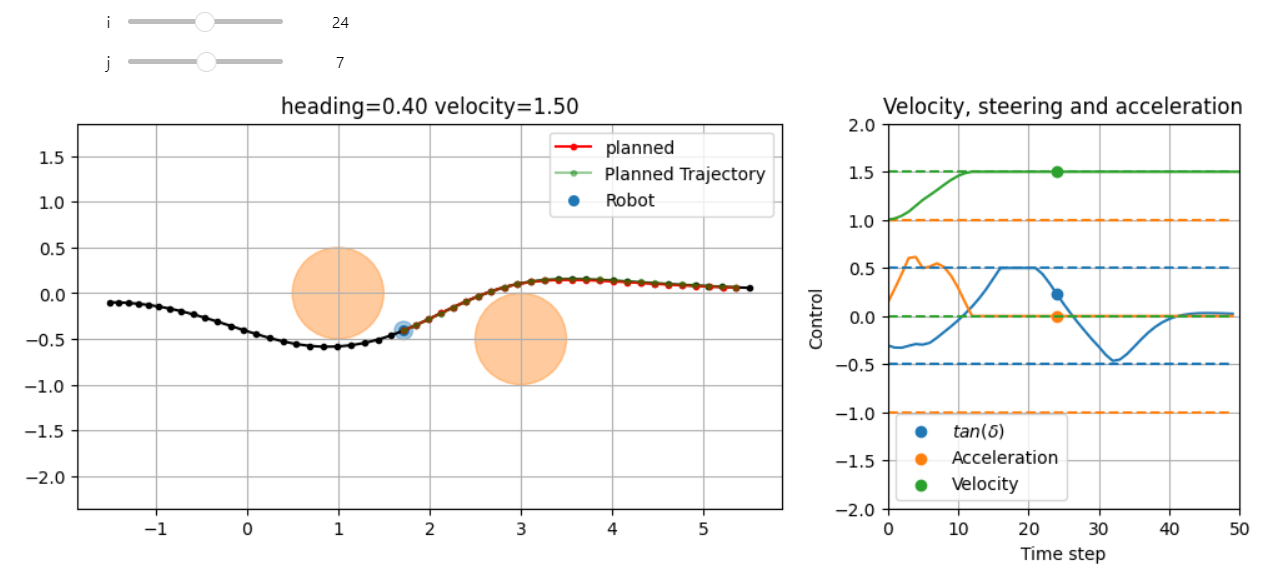

In [52]:
Image(filename='prob4q3.png')

## (d) Try out different parameter values
Try out different parameter values, cost functions, obstacle size/locations, etc and see what kind of behaviors emerge. 
As you investigate, think about things like "Are there instances where the solution isn't very good? Why is that so?" or "How much does initial guess matter?" or "Are the obstable constraints always satisfied?"
You can come up with your own questions to guide your exploration.

Share your findings/insights based on your exploration.

As we change the location of the two sphears, the trajectory does not go in between them anymore and instead just goes to the right of it. This can be a minus if you need for your objective to go in between objects. This does makes sense.

Changing markup from 1.05 to 0.95 (so from favoring big steps early to favoring big steps later on) shows a more gradual increase in velocity, and more gradual decrease in accelleration which makes sense as you want to minimize later increases, and maximize later on decreases. Both paths are pretty much the same.

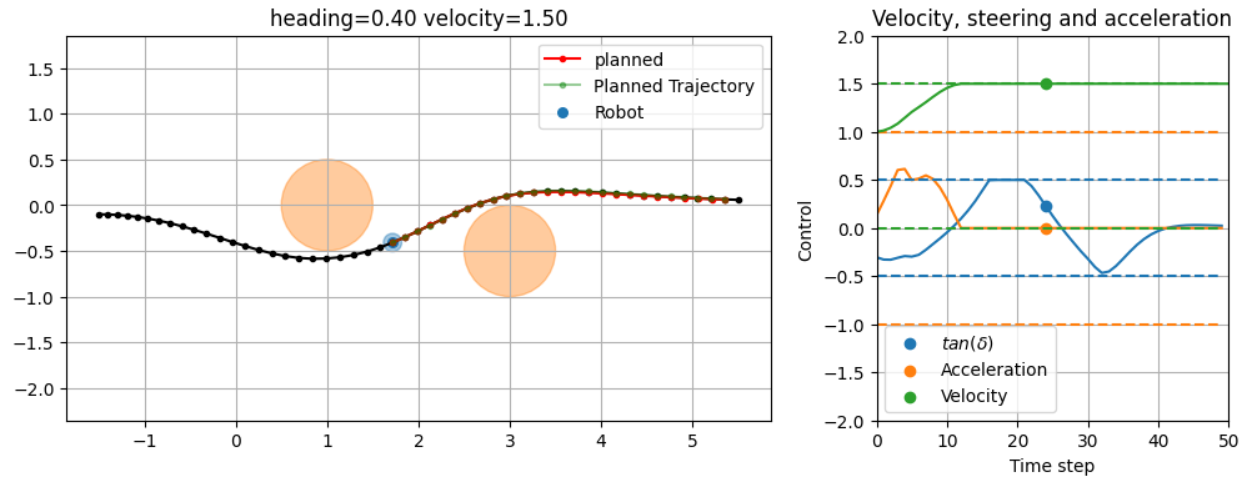

In [54]:
Image(filename='mark_up1-05.png')

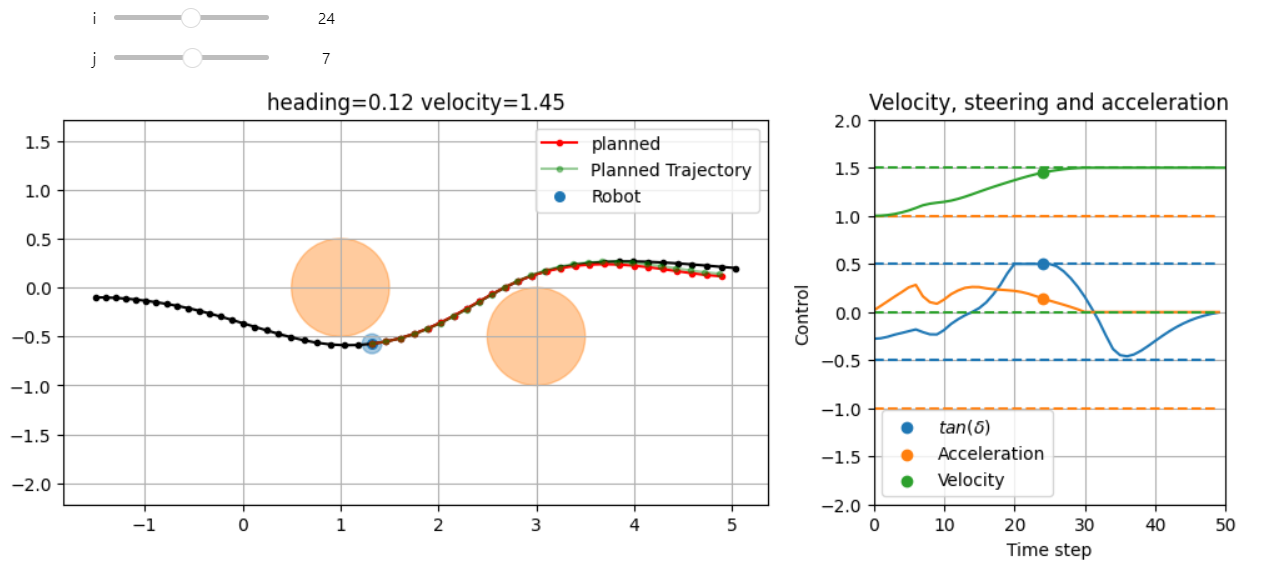

In [55]:
Image(filename='mark_up0-95.png')